# Trim all the data and build the train and dev data frames 

In [64]:
import numpy as np
import pandas as pd

# constants determined from online source 
r_0 = 0.037 # (ohms) 
q_nom = 3.350 # (Ah)
c_p = 1058 # (farads)
r_p = 0.039 # (ohms)

c = np.exp(-1 / (c_p * r_p))

In [65]:
# get the data paths 
import glob 
import os
import matplotlib.pyplot as plt

data_paths = glob.glob('data/*/*/*.csv')

In [66]:
# function to build a data frame from a path and include filename, discharge temp, discharge profile
def path_to_df(path):
    df_new = pd.read_csv(path)
    
    # add filename, discharge profile, and filename to the df columns 
    discharge_temp, discharge_profile, filename = path.split('/')[1:]
    df_new['data_path'] = path 
    df_new['discharge_temp'] = discharge_temp
    df_new['discharge_profile'] = discharge_profile 
    df_new['filename'] = filename 
    
    # check to make sure columns match expected columns 
    expected_columns = ['time_s', 'voltage_v', 'current_a', 'chargecapacity_ah', \
       'dischargecapacity_ah', 'charge_energy_wh', 'discharge_energy_wh', \
       'voltagedot_v_per_s', 'temp_degc', 'discharge_temp', \
       'discharge_profile', 'filename']
    
    for expected_column in expected_columns:
        if expected_column not in df_new.columns:
            print('missing column in {}'.format(path))
            raise
    
    return df_new

# function to downsample UDDS and US06 and trim the "charge and hold" sections of all profiles 
def trim_df(df):
    
    # downsample for UDDS and US06 profiles 
    if df['discharge_profile'].iloc[0] in ['UDDS', 'US06']:
        df = df_new.iloc[::10, :].reset_index(drop=True)
         
    # get first negative current index 
    first_neg_cur_idx = df.where(df["current_a"]<0).first_valid_index()
    
    # get last index of fully charged state (4.2V) 
    trim_idx = df.iloc[0:first_neg_cur_idx, :].where(df["voltage_v"]==4.2).last_valid_index()
    
    # slice dataframe from fully charged state to end 
    df = df.iloc[trim_idx+1:, :]
    
    # reset time index to begin from fully charged state 
    df = df.reset_index(drop=True).reset_index().drop(columns="time_s").rename(columns={"index": "time_s"}) 
    
    return df
    
# function to build state equations from known constants 
def build_df_states(df):
    n = df['current_a'].size
    
    # state variables 
    soc = np.zeros(n)
    v_p = np.zeros(n)
    
    # initial states 
    soc[0] = 100
    v_p[0] = 0 # redundant but good to note (is this a safe assumption?)
    
    for i in range(1, n):
        soc[i] = soc[i-1] - (-1) * (1 / (q_nom * 3600)) * df['current_a'].iloc[i-1] * 100
        v_p[i] = c * v_p[i-1] + (-1) * r_p * (1 - c) * df['current_a'].iloc[i-1] 
        
    df['soc'] = soc 
    df['v_p'] = v_p 
        
    return df

In [67]:
# build the train and dev sets 
dev_paths = ['data/T25/3C/3.csv', 'data/T05/HPPC/5.csv', 'data/T25/UDDS/1.csv', 'data/T35/US06/4.csv']

df_train = pd.DataFrame() 
df_dev = pd.DataFrame() 

for data_path in data_paths:
    df_new = path_to_df(data_path)
    
    df_new = trim_df(df_new)
    
    df_new = build_df_states(df_new)
    
    if data_path in dev_paths:
        df_dev = df_dev.append(df_new)
    else:
        df_train = df_train.append(df_new)

df_train = df_train.reset_index()
df_dev = df_dev.reset_index()

# Model Training 

## Circuit Model: Calculate Voc (via plots) and R0 (via LS) 

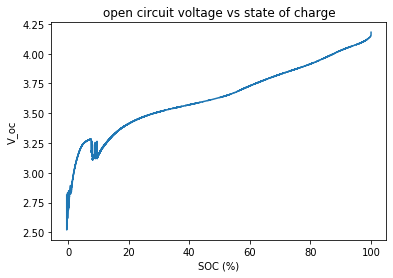

In [68]:
# calculate v_oc from 0_05C discharge profile -> function of soc bin 
v_oc_levels = 1000
if (v_oc_levels % 10 != 0) or (v_oc_levels < 100):
    print('invalid number of bins specified for v_oc')
    raise

decimals = int(np.log(v_oc_levels / 100))

df_train['soc_rounded'] = df_train['soc'].round(decimals)
df_dev['soc_rounded'] = df_dev['soc'].round(decimals)

df_train_005C = df_train[df_train['discharge_profile'] == '0_05C']
v_oc = df_train_005C[['soc_rounded','voltage_v']].groupby('soc_rounded').mean()
v_oc = v_oc.rename(columns={"voltage_v": "v_oc"}).reset_index()

plt.plot(v_oc['soc_rounded'], v_oc['v_oc'])
plt.title('open circuit voltage vs state of charge')
plt.ylabel('V_oc')
plt.xlabel('SOC (%)')

if 'v_oc' in df_train.columns:
    df_train = df_train.drop(['v_oc'], axis=1)
if 'v_oc' in df_dev.columns:
    df_dev = df_dev.drop(['v_oc'], axis=1)

df_train = pd.merge(df_train, v_oc, how = 'left', on = 'soc_rounded')
df_dev = pd.merge(df_dev, v_oc, how = 'left', on = 'soc_rounded')

In [69]:
# calculate R0 using LS
A = np.zeros((df_train['current_a'].size,1))
A[:,0] = df_train['current_a']

y = np.zeros((df_train['voltage_v'].size,1))
y[:,0] = df_train['voltage_v']

b = np.zeros((df_train['voltage_v'].size,1))
b[:,0] = df_train['v_oc'] - df_train['v_p']

x = np.linalg.lstsq(A, y-b, rcond=None)
r_0 = x[0][0]
print('r_0 = {}'.format(r_0))

r_0 = [0.05084878]


## ML Models 

In [70]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression

features = ['current_a','soc']
X = df_train[features]
y = df_train['voltage_v']

# Linear Regression 
print('fitting linear regression model')
model_reg = LinearRegression().fit(X, y)

# relu nn
print('fitting relu nn model')
model_nn_relu = MLPRegressor(solver='adam', activation = 'relu', alpha=1e-5, \
                        hidden_layer_sizes=(8, 4, 2), random_state=1, learning_rate = 'adaptive').fit(X, y)

# tanh nn
print('fitting tanh nn model')
model_nn_tanh = MLPRegressor(solver='adam', activation = 'tanh', alpha=1e-5, \
                        hidden_layer_sizes=(8, 4, 2), random_state=1, learning_rate = 'adaptive').fit(X, y)

fitting linear regression model
fitting relu nn model
fitting tanh nn model


# Model Testing 

In [90]:
# prediction results 
df_costs = pd.DataFrame(index = dev_paths, \
                        columns = ['circuit','reg','nn_relu','nn_tanh'])

## Circuit Testing

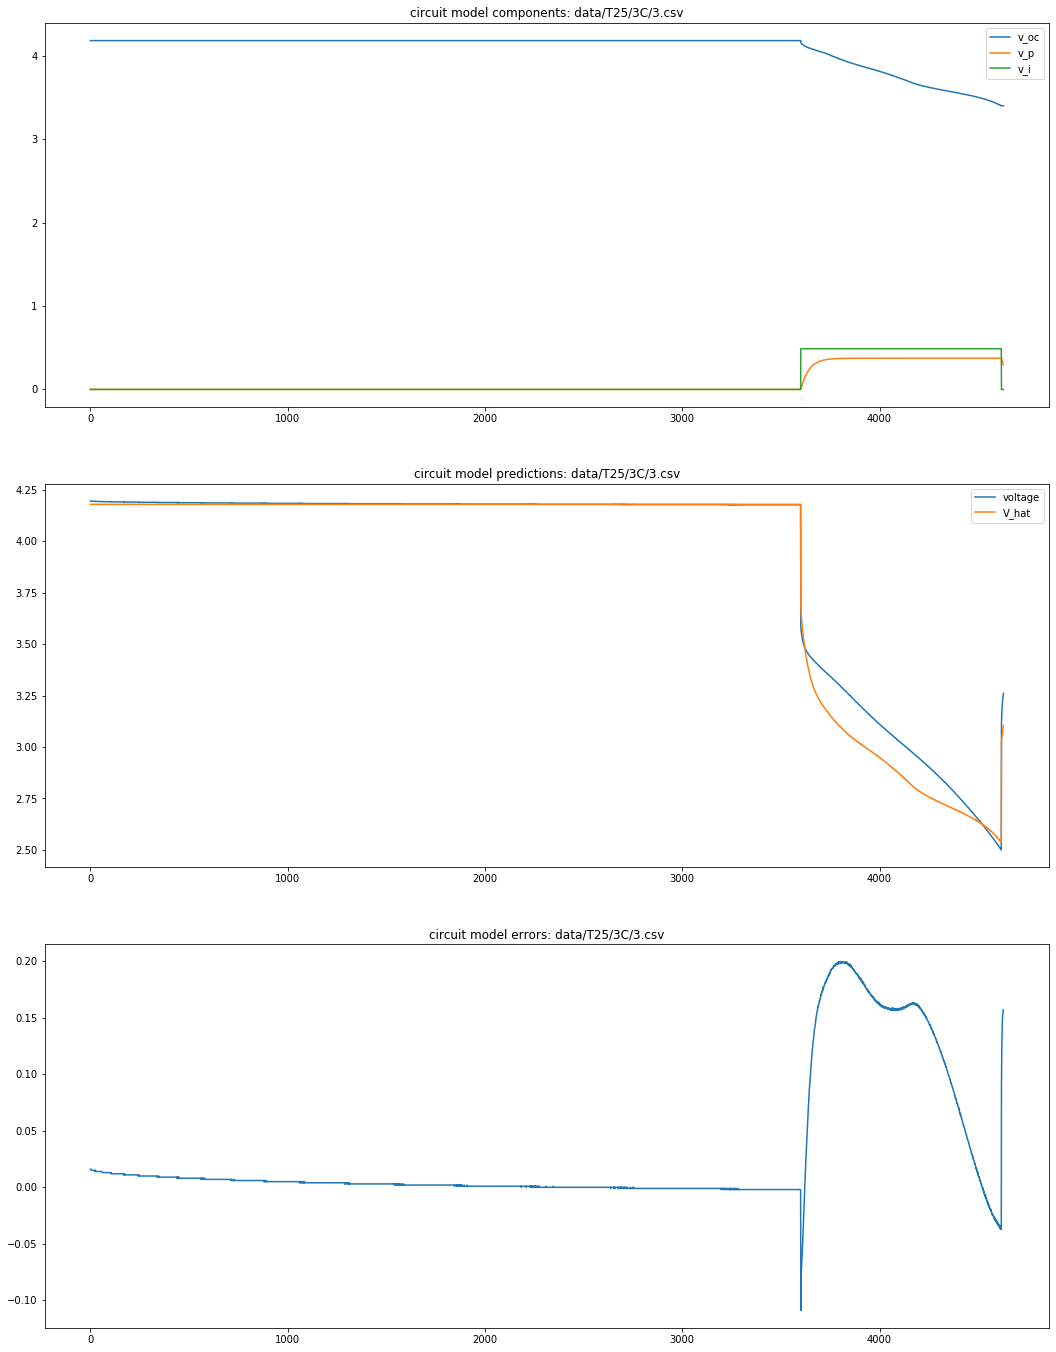

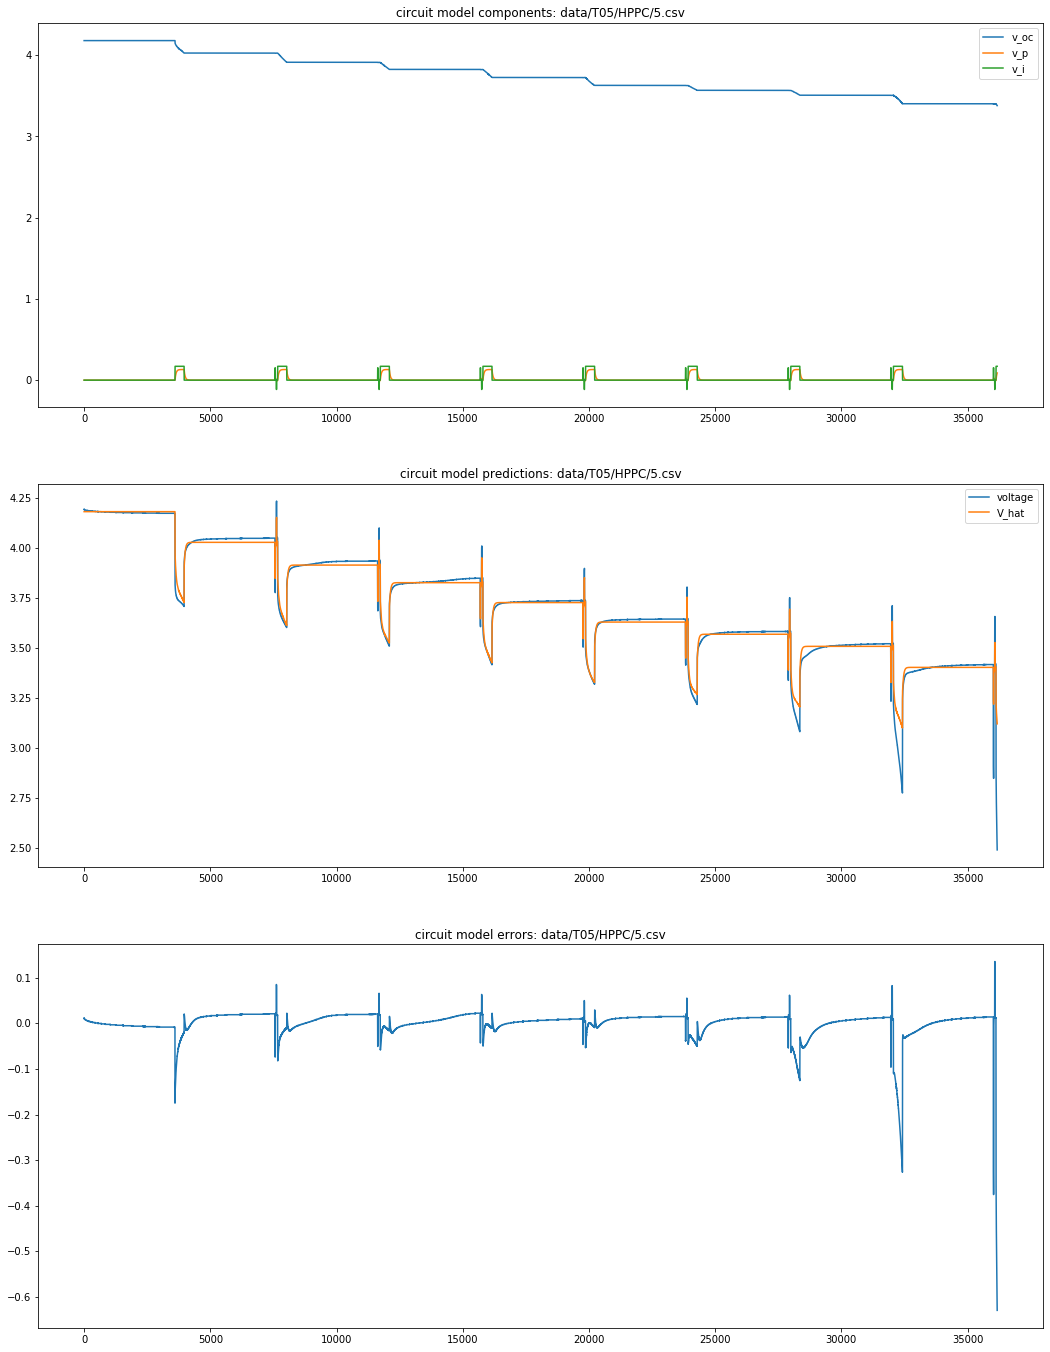

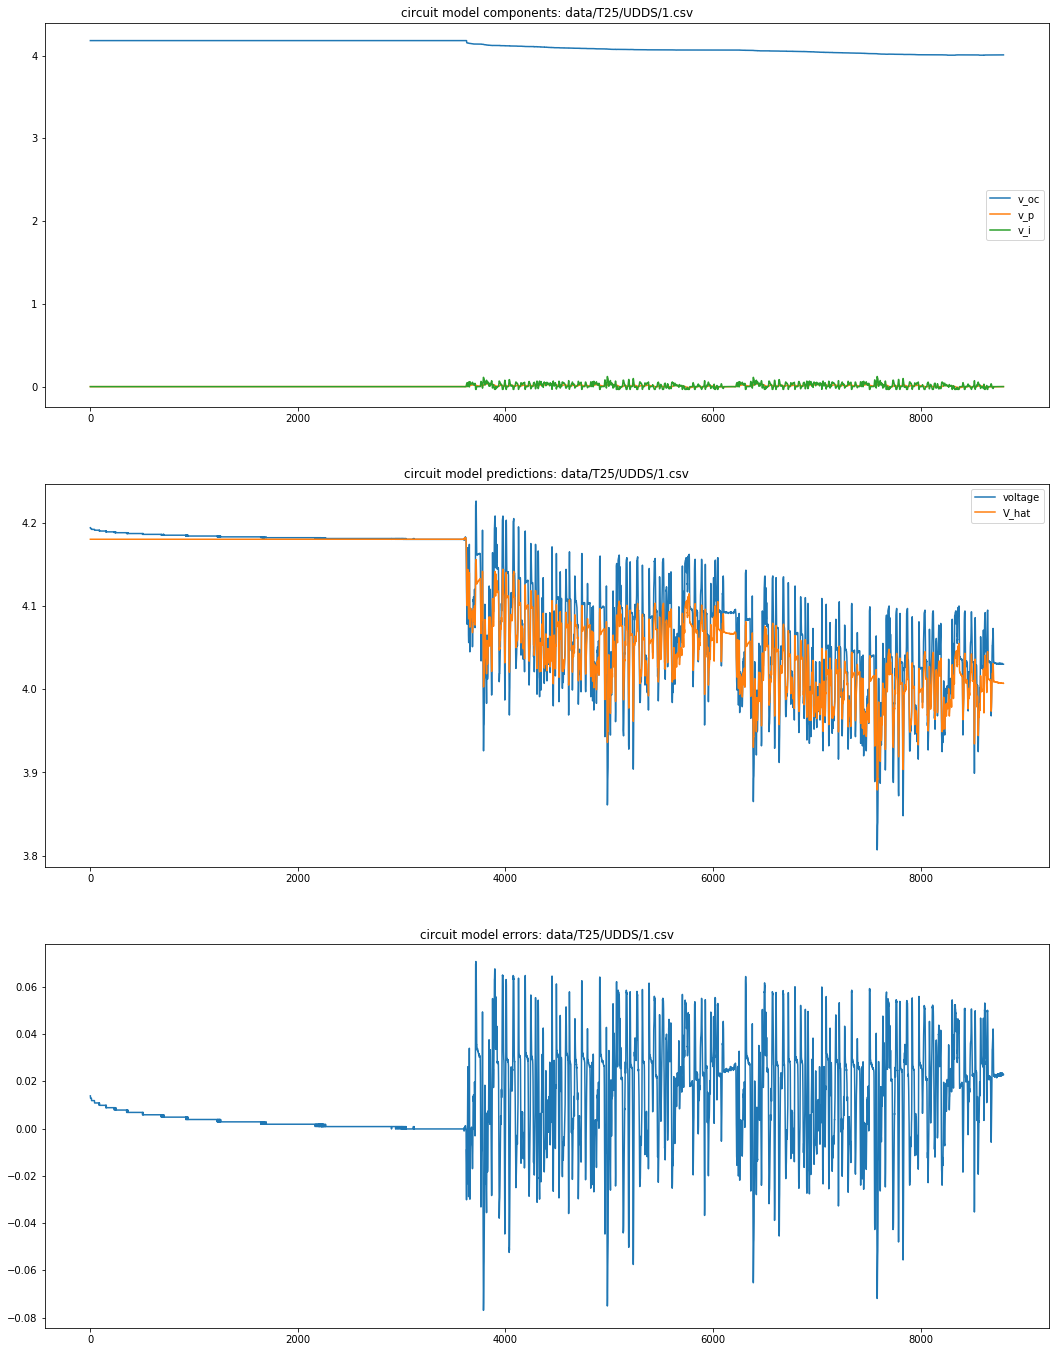

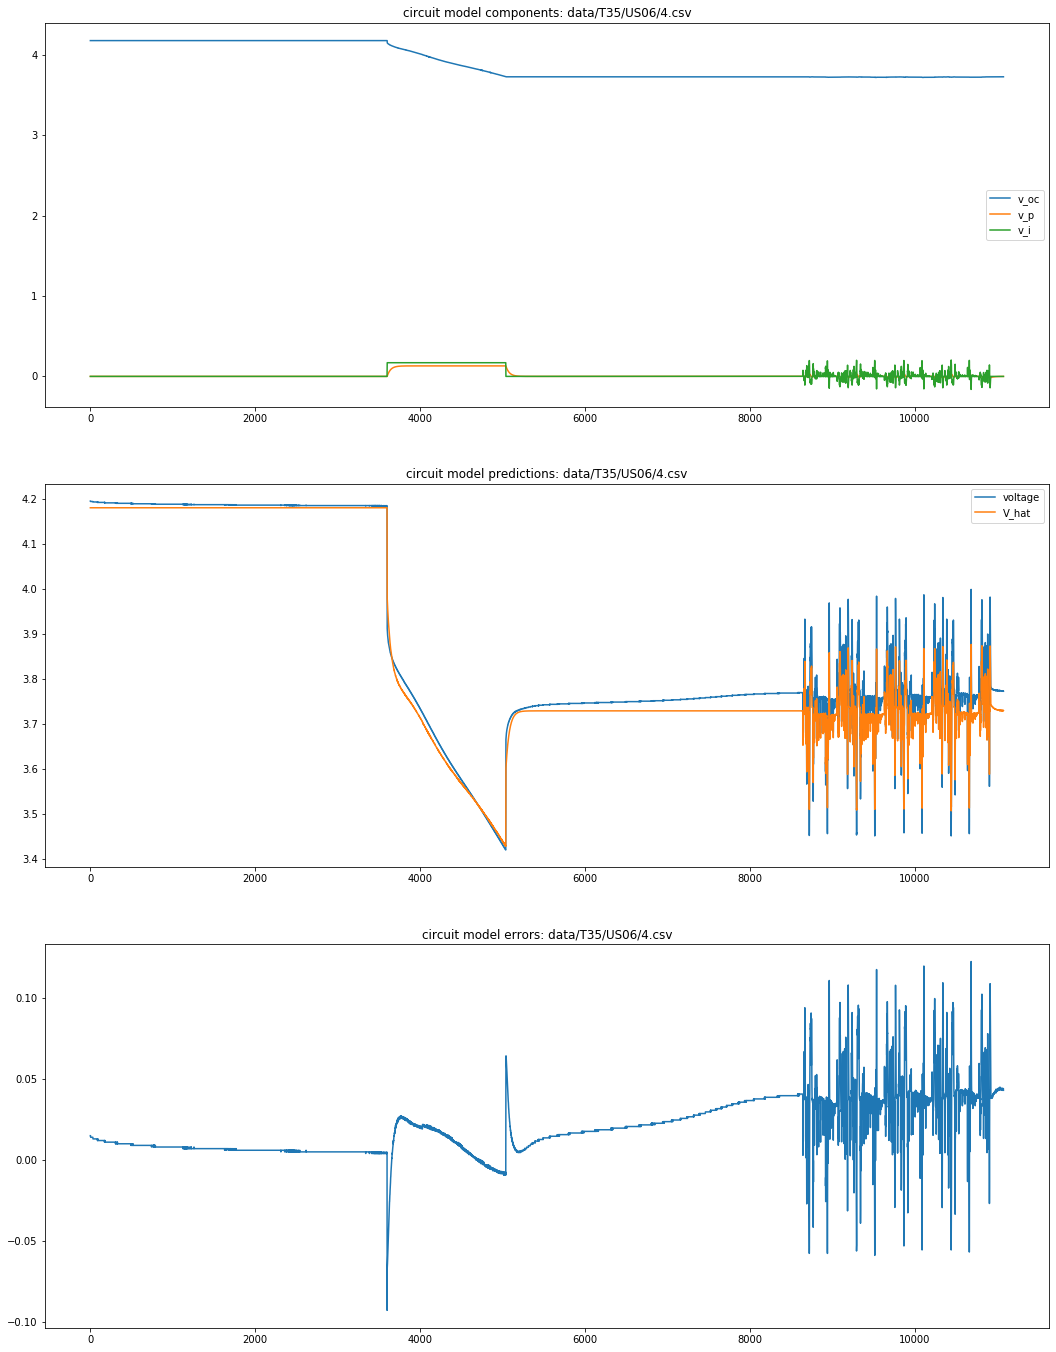

In [92]:
# Plot circuit results 
for dev_path in dev_paths:
    costs = pd.DataFrame(index = [df_dev['data_path'].unique()], columns = ['model'])

    voltage = pd.DataFrame.to_numpy(df_dev['voltage_v'][df_dev['data_path'] == dev_path])
    v_oc = pd.DataFrame.to_numpy(df_dev['v_oc'][df_dev['data_path'] == dev_path])
    v_p = pd.DataFrame.to_numpy(df_dev['v_p'][df_dev['data_path'] == dev_path])
    v_i = pd.DataFrame.to_numpy(df_dev['current_a'][df_dev['data_path'] == dev_path] * r_0)
    v_hat = v_oc - v_p - (-1) * v_i 
    
    cost = np.mean(np.power(voltage - v_hat,2))
    df_costs['circuit'].loc[dev_path] = cost 

    # plot circuit model components, predictions, and error 
    fig=plt.figure(figsize=(18, 24))

    plt.subplot(3,1,1)
    plt.plot(v_oc)
    plt.plot(v_p)
    plt.plot((-1) * v_i)
    plt.title('circuit model components: {}'.format(dev_path))
    plt.legend(['v_oc', 'v_p', 'v_i'])

    plt.subplot(3,1,2)
    plt.plot(voltage)
    plt.plot(v_hat)
    plt.title('circuit model predictions: {}'.format(dev_path))
    plt.legend(['voltage', 'V_hat'])

    plt.subplot(3,1,3)
    plt.plot(voltage - v_hat)
    plt.title('circuit model errors: {}'.format(dev_path))

## ML Testing 

In [105]:
def ml_preds(model, df_dev, df_cost, verbose = True):
    for dev_path in df_dev['data_path'].unique():
        X = df_dev[features][df_dev['data_path'] == dev_path].reset_index(drop=True)
        y = df_dev['voltage_v'][df_dev['data_path'] == dev_path].reset_index(drop=True)
        
        pred = model.predict(X)
        
        cost = np.mean((pred - y) ** 2)
        df_cost.loc[dev_path] = cost 
        
        if verbose:
            fig=plt.figure(figsize=(18, 8))
            plt.plot(y)
            plt.plot(pred)
            plt.title(dev_path)
            plt.legend(['true voltage','predicted voltage'])

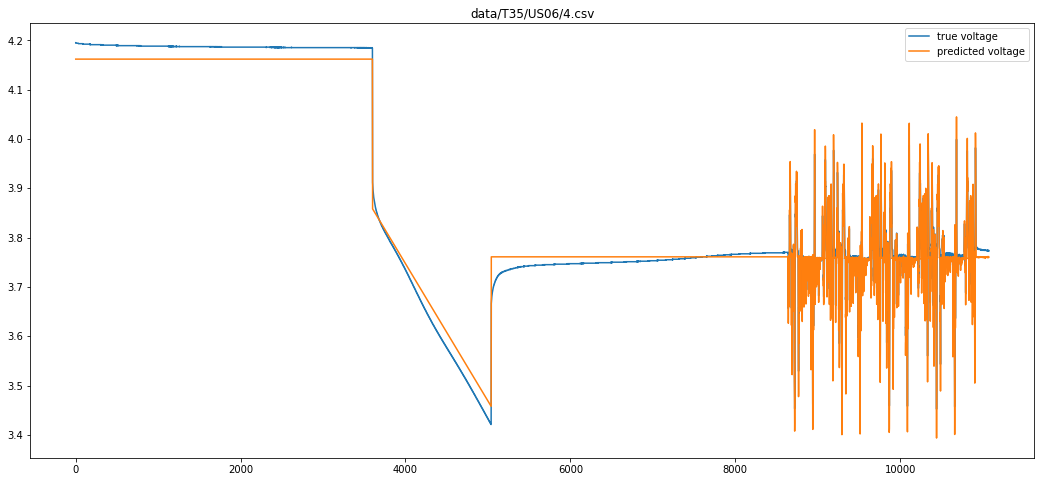

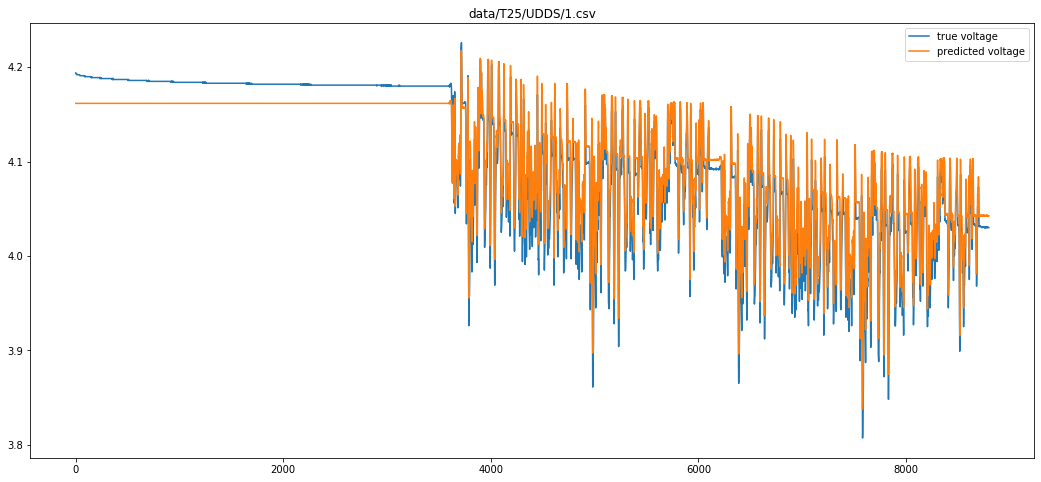

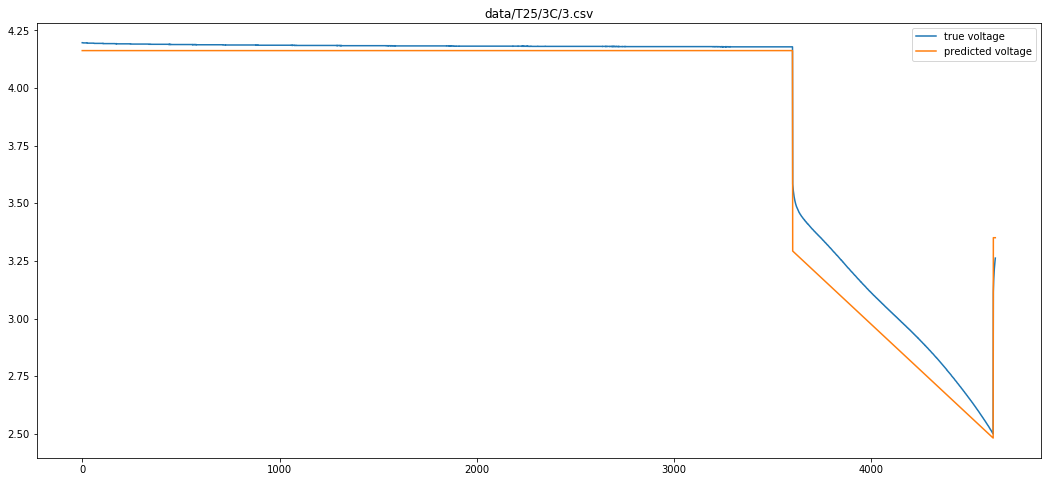

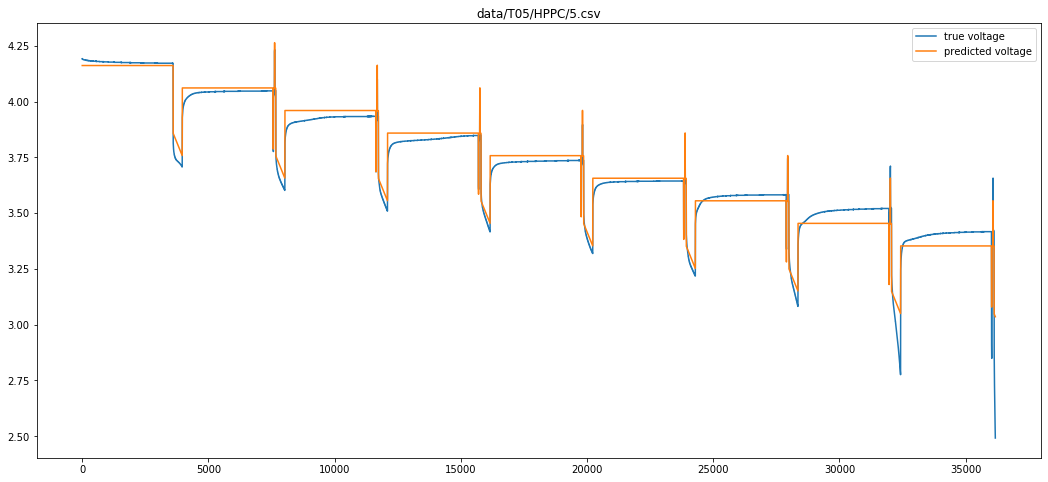

In [106]:
ml_preds(model_reg, df_dev, df_costs['reg'])

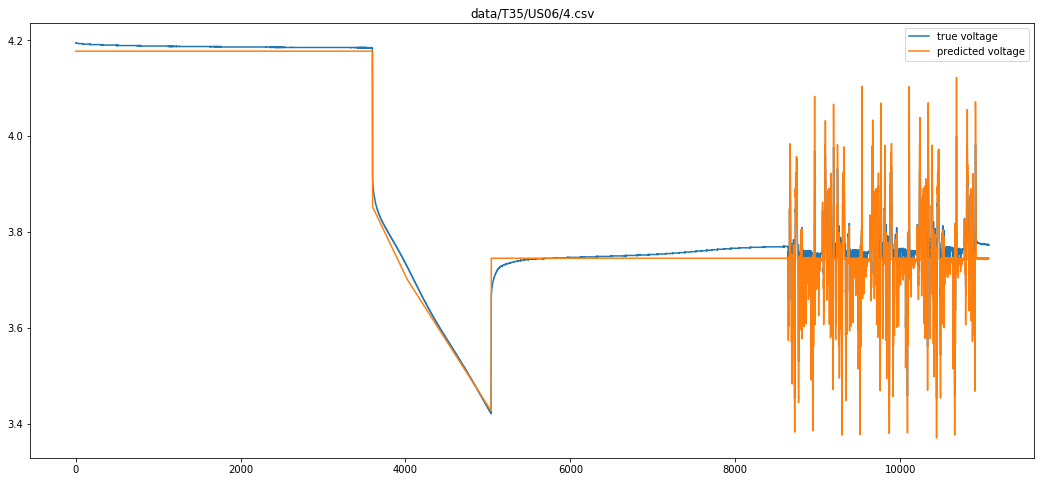

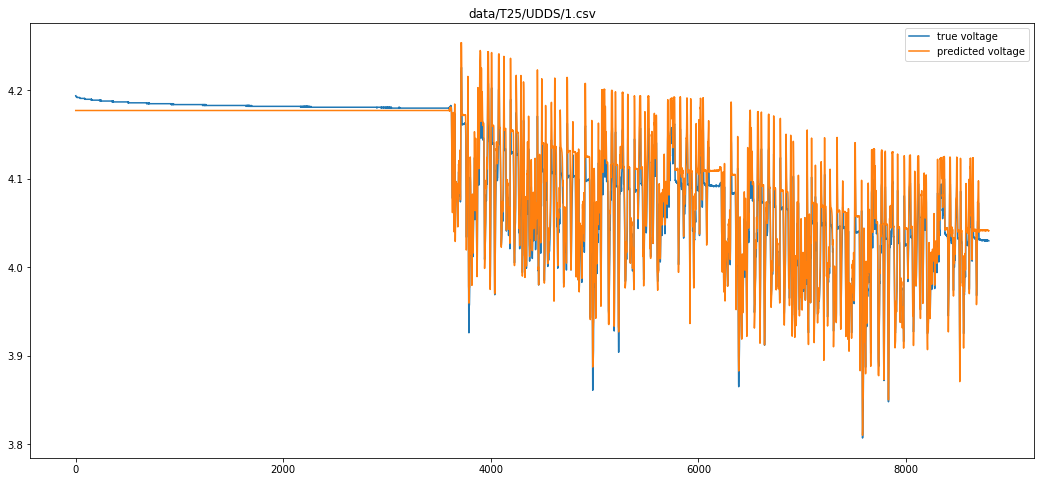

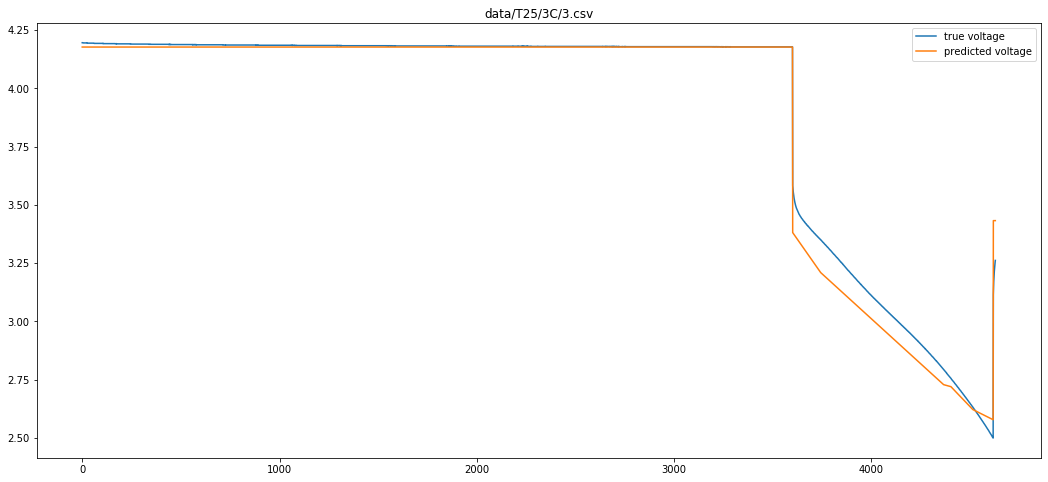

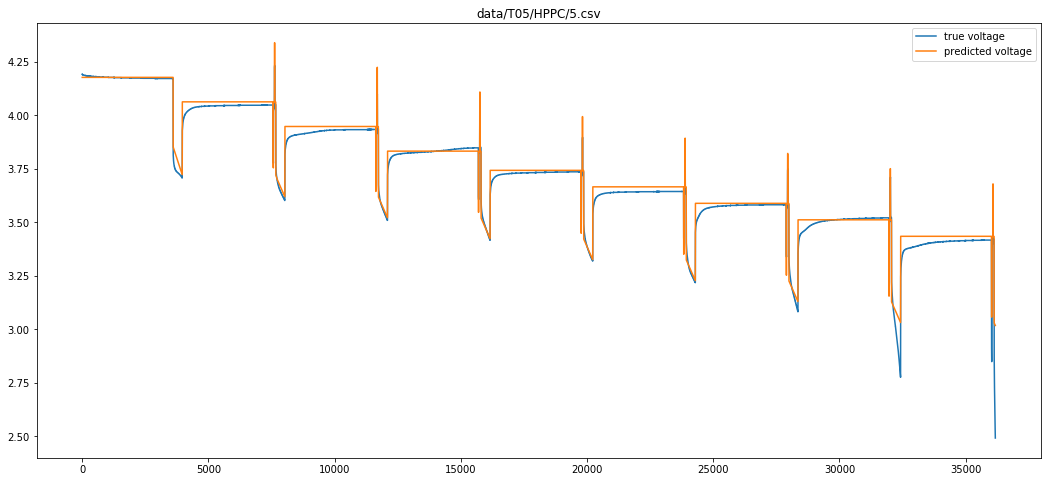

In [107]:
ml_preds(model_nn_relu, df_dev, df_costs['nn_relu'])

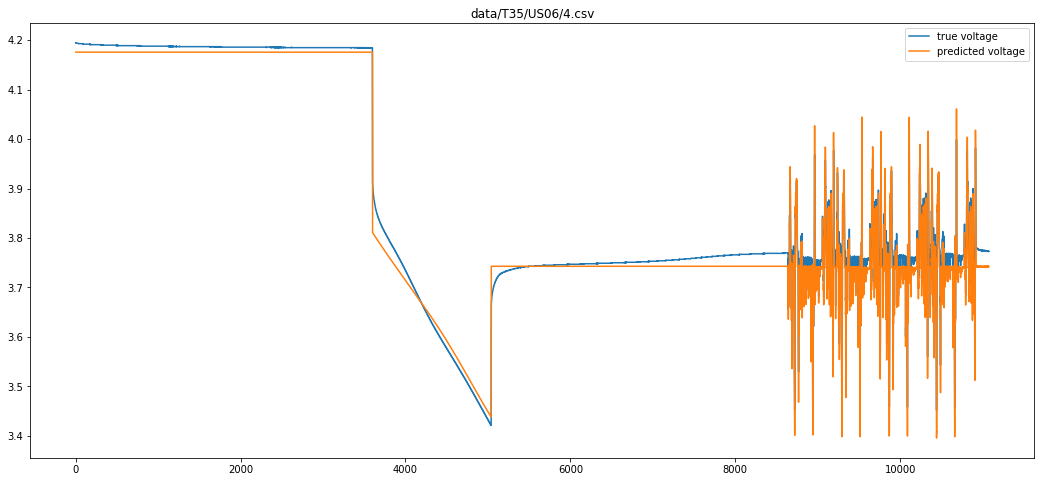

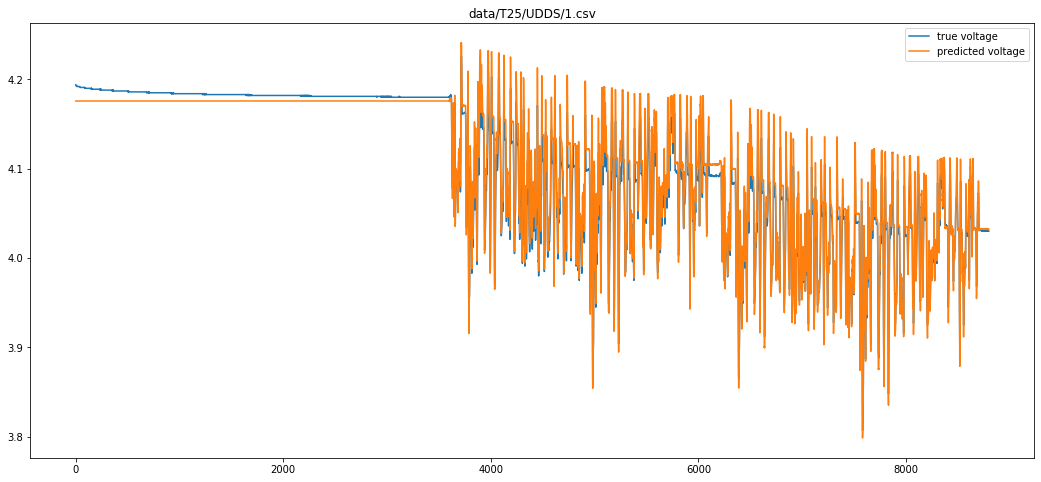

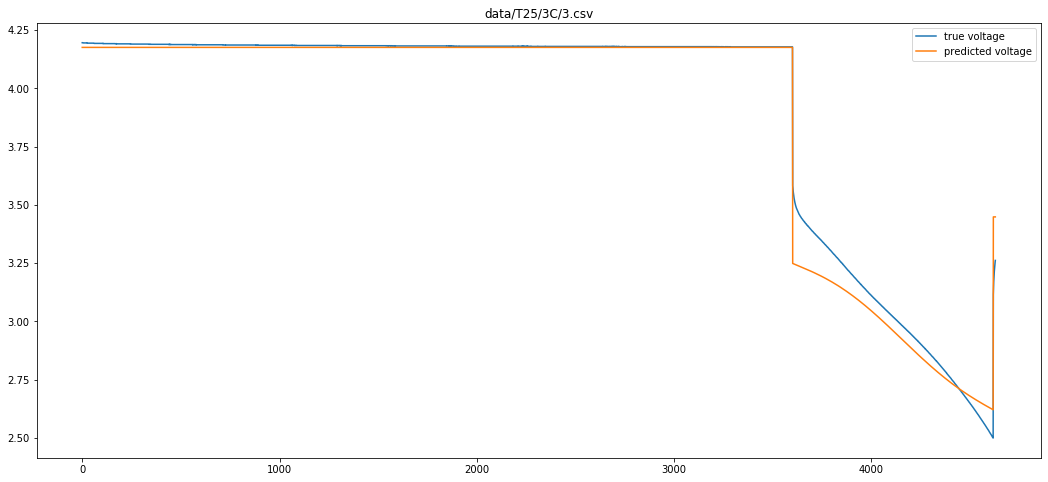

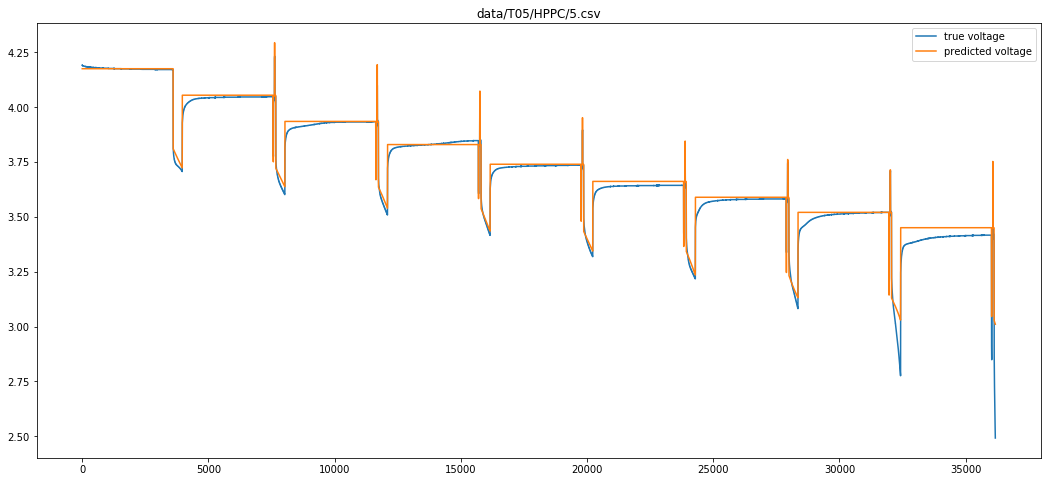

In [108]:
ml_preds(model_nn_tanh, df_dev, df_costs['nn_tanh'])

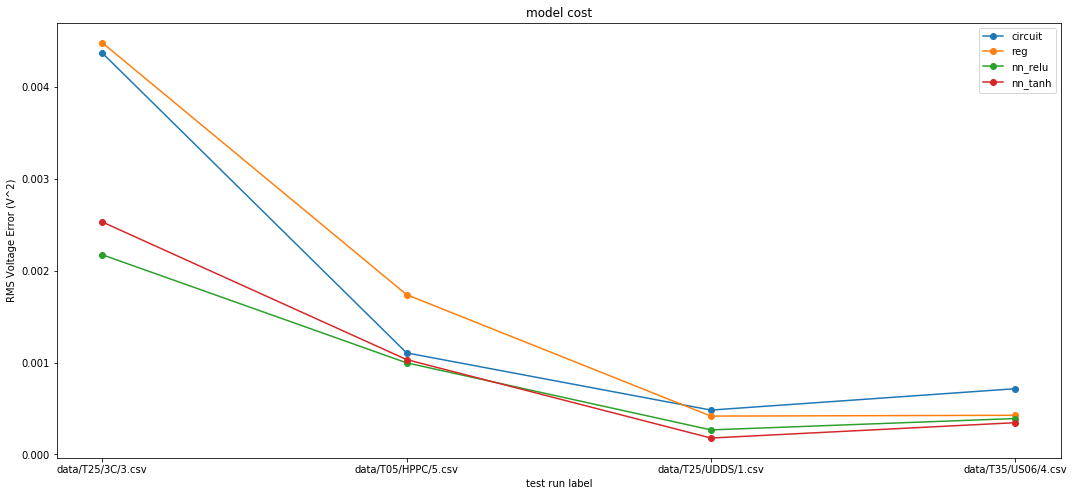

In [123]:
fig=plt.figure(figsize=(18, 8))

plt.plot(df_costs, '-o');
plt.legend(df_costs.columns);
plt.title('model cost');
plt.ylabel('RMS Voltage Error (V^2)');
plt.xlabel('test run label');